# 70. 単語ベクトルの和による特徴量

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# データの読込
df = pd.read_csv('newsCorpora.csv', header=None, sep='\t', names=['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP'])

# データの抽出
df = df.loc[df['PUBLISHER'].isin(['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail']), ['TITLE', 'CATEGORY']]

# データの分割
train, valid_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=123, stratify=df['CATEGORY'])
valid, test = train_test_split(valid_test, test_size=0.5, shuffle=True, random_state=123, stratify=valid_test['CATEGORY'])

# 事例数の確認
print('【学習データ】')
print(train['CATEGORY'].value_counts())
print('【検証データ】')
print(valid['CATEGORY'].value_counts())
print('【評価データ】')
print(test['CATEGORY'].value_counts())

【学習データ】
b    4502
e    4223
t    1219
m     728
Name: CATEGORY, dtype: int64
【検証データ】
b    562
e    528
t    153
m     91
Name: CATEGORY, dtype: int64
【評価データ】
b    563
e    528
t    152
m     91
Name: CATEGORY, dtype: int64


In [5]:
from gensim.models import KeyedVectors
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [6]:
import string
import torch

def transform_w2v(text):
    table = str.maketrans(string.punctuation, ' '*len(string.punctuation)) #記号をスペースに置換
    words = text.translate(table).split()  # スペースで分割してリスト化
    vec = [model[word] for word in words if word in model]  # 1語ずつベクトル化

    return torch.tensor(sum(vec) / len(vec))  # 平均ベクトルをTensor型に変換して出力

In [7]:
# 特徴ベクトルの作成
X_train = torch.stack([transform_w2v(text) for text in train['TITLE']])
X_valid = torch.stack([transform_w2v(text) for text in valid['TITLE']])
X_test = torch.stack([transform_w2v(text) for text in test['TITLE']])

print(X_train.size())
print(X_train)

torch.Size([10672, 300])
tensor([[-0.0170,  0.1318, -0.0728,  ...,  0.0395,  0.0223,  0.0184],
        [-0.1119, -0.0523, -0.1002,  ...,  0.0319, -0.0237, -0.0425],
        [-0.0636, -0.0228, -0.0005,  ..., -0.0280,  0.1057,  0.0396],
        ...,
        [ 0.0301, -0.0355, -0.0082,  ..., -0.0045,  0.0606, -0.0281],
        [ 0.0002,  0.0442, -0.0424,  ..., -0.0507,  0.0283,  0.0365],
        [ 0.0242,  0.0418,  0.1211,  ..., -0.0564,  0.0144,  0.0277]])


In [8]:
# ラベルベクトルの作成
category_dict = {'b': 0, 't': 1, 'e':2, 'm':3}
y_train = torch.tensor(train['CATEGORY'].map(lambda x: category_dict[x]).values)
y_valid = torch.tensor(valid['CATEGORY'].map(lambda x: category_dict[x]).values)
y_test = torch.tensor(test['CATEGORY'].map(lambda x: category_dict[x]).values)

print(y_train.size())
print(y_train)

torch.Size([10672])
tensor([0, 0, 0,  ..., 0, 2, 2])


In [9]:
# ファイルに保存
torch.save(X_train, 'X_train.pt')
torch.save(X_valid, 'X_valid.pt')
torch.save(X_test, 'X_test.pt')
torch.save(y_train, 'y_train.pt')
torch.save(y_valid, 'y_valid.pt')
torch.save(y_test, 'y_test.pt')

# 71. 単層ニューラルネットワークによる予測

In [10]:
from torch import nn

class SLPNet(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.fc = nn.Linear(input_size, output_size, bias=False)
        nn.init.normal_(self.fc.weight, 0.0, 1.0)  

    def forward(self, x):
        x = self.fc(x)
        return x

In [11]:
model = SLPNet(300, 4)  # 単層ニューラルネットワークの初期化
y_hat_1 = torch.softmax(model(X_train[:1]), dim=-1)
print(y_hat_1)

tensor([[3.5117e-02, 4.0947e-04, 9.5745e-01, 7.0186e-03]],
       grad_fn=<SoftmaxBackward>)


In [12]:
Y_hat = torch.softmax(model.forward(X_train[:4]), dim=-1)
print(Y_hat)

tensor([[3.5117e-02, 4.0947e-04, 9.5745e-01, 7.0186e-03],
        [9.4870e-03, 8.6065e-01, 9.4553e-02, 3.5306e-02],
        [8.2991e-02, 9.1011e-02, 4.9685e-01, 3.2914e-01],
        [1.5800e-01, 4.5089e-01, 1.8030e-01, 2.1081e-01]],
       grad_fn=<SoftmaxBackward>)


# 72. 損失と勾配の計算

In [14]:
criterion = nn.CrossEntropyLoss()

l_1 = criterion(model(X_train[:1]), y_train[:1])  # 入力ベクトルはsoftmax前の値
model.zero_grad()  # 勾配をゼロで初期化
l_1.backward()  # 勾配を計算
print(f'損失: {l_1:.4f}')
print(f'勾配:\n{model.fc.weight.grad}')

損失: 3.3491
勾配:
tensor([[ 1.6365e-02, -1.2713e-01,  7.0199e-02,  ..., -3.8103e-02,
         -2.1496e-02, -1.7710e-02],
        [-6.9447e-06,  5.3952e-05, -2.9791e-05,  ...,  1.6170e-05,
          9.1222e-06,  7.5156e-06],
        [-1.6239e-02,  1.2615e-01, -6.9659e-02,  ...,  3.7810e-02,
          2.1330e-02,  1.7574e-02],
        [-1.1904e-04,  9.2476e-04, -5.1063e-04,  ...,  2.7716e-04,
          1.5636e-04,  1.2882e-04]])


In [15]:
l = criterion(model(X_train[:4]), y_train[:4])
model.zero_grad()
l.backward()
print(f'損失: {l:.4f}')
print(f'勾配:\n{model.fc.weight.grad}')

損失: 3.0853
勾配:
tensor([[ 0.0522, -0.0449,  0.0438,  ..., -0.0116, -0.0216, -0.0039],
        [-0.0286,  0.0050, -0.0223,  ...,  0.0065, -0.0038, -0.0077],
        [-0.0159,  0.0342, -0.0201,  ...,  0.0069,  0.0174,  0.0085],
        [-0.0077,  0.0057, -0.0014,  ..., -0.0018,  0.0080,  0.0031]])


# 73. 確率的勾配降下法による学習
確率的勾配降下法（SGD: Stochastic Gradient Descent）を用いて，行列W
を学習せよ．なお，学習は適当な基準で終了させればよい（例えば「100エポックで終了」など）．

In [16]:
from torch.utils.data import Dataset

class NewsDataset(Dataset):
    def __init__(self, X, y):  # datasetの構成要素を指定
        self.X = X
        self.y = y

    def __len__(self):  # len(dataset)で返す値を指定
        return len(self.y)

    def __getitem__(self, idx):  # dataset[idx]で返す値を指定
        return [self.X[idx], self.y[idx]]

In [18]:
from torch.utils.data import DataLoader

# Datasetの作成
dataset_train = NewsDataset(X_train, y_train)
dataset_valid = NewsDataset(X_valid, y_valid)
dataset_test = NewsDataset(X_test, y_test)

# Dataloaderの作成
dataloader_train = DataLoader(dataset_train, batch_size=1, shuffle=True)
dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)
dataloader_test = DataLoader(dataset_test, batch_size=len(dataset_test), shuffle=False)

In [19]:
# モデルの定義
model = SLPNet(300, 4)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

# 学習
num_epochs = 10

for epoch in range(num_epochs):

    model.train()
    loss_train = 0.0
    for i, (inputs, labels) in enumerate(dataloader_train):
    # 勾配をゼロで初期化
        optimizer.zero_grad()

    # 順伝播 + 誤差逆伝播 + 重み更新
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # 損失を記録
        loss_train += loss.item()

  # バッチ単位の平均損失計算
    loss_train = loss_train / i

  # 検証データの損失計算
    model.eval() 
    with torch.no_grad():
        inputs, labels = next(iter(dataloader_valid))
        outputs = model(inputs)
        loss_valid = criterion(outputs, labels)

  # ログを出力
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, loss_valid: {loss_valid:.4f}')  

epoch: 1, loss_train: 0.4810, loss_valid: 0.3630
epoch: 2, loss_train: 0.3227, loss_valid: 0.3119
epoch: 3, loss_train: 0.2920, loss_valid: 0.2949
epoch: 4, loss_train: 0.2766, loss_valid: 0.2934
epoch: 5, loss_train: 0.2651, loss_valid: 0.2799
epoch: 6, loss_train: 0.2579, loss_valid: 0.2753
epoch: 7, loss_train: 0.2523, loss_valid: 0.2722
epoch: 8, loss_train: 0.2475, loss_valid: 0.2724
epoch: 9, loss_train: 0.2440, loss_valid: 0.2732
epoch: 10, loss_train: 0.2408, loss_valid: 0.2714


# 74. 正解率の計測
問題73で求めた行列を用いて学習データおよび評価データの事例を分類したとき，その正解率をそれぞれ求めよ．

In [20]:
def calculate_accuracy(model, loader):
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            pred = torch.argmax(outputs, dim=-1)
            total += len(inputs)
            correct += (pred == labels).sum().item()

    return correct / total

In [21]:
acc_train = calculate_accuracy(model, dataloader_train)
acc_test = calculate_accuracy(model, dataloader_test)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

正解率（学習データ）：0.922
正解率（評価データ）：0.913


# 75. 損失と正解率のプロット
問題73のコードを改変し，各エポックのパラメータ更新が完了するたびに，訓練データでの損失，正解率，検証データでの損失，正解率をグラフにプロットし，学習の進捗状況を確認できるようにせよ．

In [22]:
def calculate_loss_and_accuracy(model, criterion, loader):
    model.eval()
    loss = 0.0
    total = 0
    correct = 0
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            loss += criterion(outputs, labels).item()
            pred = torch.argmax(outputs, dim=-1)
            total += len(inputs)
            correct += (pred == labels).sum().item()

    return loss / len(loader), correct / total

In [23]:
# モデルの定義
model = SLPNet(300, 4)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

# 学習
num_epochs = 30

log_train = []
log_valid = []

for epoch in range(num_epochs):

    model.train()
    for i, (inputs, labels) in enumerate(dataloader_train):
    # 勾配をゼロで初期化
        optimizer.zero_grad()

    # 順伝播 + 誤差逆伝播 + 重み更新
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # 損失と正解率の算出
    loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train)
    loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

  # ログを出力
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}')  

epoch: 1, loss_train: 0.3337, accuracy_train: 0.8856, loss_valid: 0.3532, accuracy_valid: 0.8771
epoch: 2, loss_train: 0.2949, accuracy_train: 0.8997, loss_valid: 0.3197, accuracy_valid: 0.8906
epoch: 3, loss_train: 0.2725, accuracy_train: 0.9079, loss_valid: 0.2978, accuracy_valid: 0.8996
epoch: 4, loss_train: 0.2604, accuracy_train: 0.9109, loss_valid: 0.2886, accuracy_valid: 0.8988
epoch: 5, loss_train: 0.2519, accuracy_train: 0.9139, loss_valid: 0.2813, accuracy_valid: 0.9055
epoch: 6, loss_train: 0.2483, accuracy_train: 0.9135, loss_valid: 0.2808, accuracy_valid: 0.8996
epoch: 7, loss_train: 0.2477, accuracy_train: 0.9148, loss_valid: 0.2786, accuracy_valid: 0.9010
epoch: 8, loss_train: 0.2361, accuracy_train: 0.9187, loss_valid: 0.2724, accuracy_valid: 0.9063
epoch: 9, loss_train: 0.2332, accuracy_train: 0.9192, loss_valid: 0.2708, accuracy_valid: 0.9033
epoch: 10, loss_train: 0.2301, accuracy_train: 0.9205, loss_valid: 0.2696, accuracy_valid: 0.9085
epoch: 11, loss_train: 0.2303

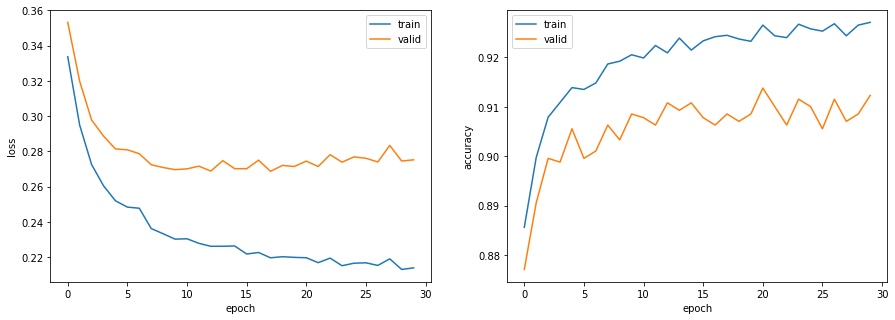

In [24]:
from matplotlib import pyplot as plt

# グラフ化
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(np.array(log_train).T[0], label='train')
ax[0].plot(np.array(log_valid).T[0], label='valid')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[1].plot(np.array(log_train).T[1], label='train')
ax[1].plot(np.array(log_valid).T[1], label='valid')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()
plt.show()